El siguiente código presenta un tratamiento y análisis de transporte de pasajeros de transporte terrestre en Colombia desde el años 2019.
La data proviene del recurso público https://www.datos.gov.co/Transporte/Operaci-n-de-pasajeros-y-despacho-de-veh-culos-en-/eh75-8ah6, y el documento de códificación de municipios desde https://geoportal.dane.gov.co/geovisores/territorio/consulta-divipola-division-politico-administrativa-de-colombia/

La explicación de observaciones se evidencia en puntos específicos y después de algunas gráficas realizadas.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import requests
from io import StringIO
from openpyxl import load_workbook
from io import BytesIO

# **Exportación y preprocesamiento de datos**

Antes de comenzar con el trabajo de análisis se implementará un primer tratamiento que constará de agregar los datos de DIVIPOLA extraidos del DANE al archivo de operación terrestre extraido de Datos.gov

In [7]:
#Datos directamente desde la API
# Definir la URL base
base_url = "https://www.datos.gov.co/resource/eh75-8ah6.csv"
response = requests.get(base_url)


# Obtener el año actual
current_year = pd.to_datetime("today").year

# Crear una lista para almacenar los DataFrames por año
dataframes = []

# Iterar a través de los años desde 2019 hasta el año actual
for year in range(2019, current_year + 1):
    # Construir la URL para el año actual
    year_url = f"{base_url}?$where=fecha_despacho between '{year}-01-01T00:00:00' and '{year}-12-31T00:00:00'&$limit=10000000"
    # Realizar una solicitud GET a la URL y obtener el contenido del CSV
    response = requests.get(year_url)
    
    # Crear un DataFrame a partir del contenido del CSV
    df = pd.read_csv(StringIO(response.text))
    
    # Agregar el DataFrame a la lista
    dataframes.append(df)

# Concatenar todos los DataFrames en uno solo
data = pd.concat(dataframes, ignore_index=True)
data.columns = map(str.upper, data.columns)
# Ahora tienes todos los datos en full_data
print(data.head())

         TERMINAL CLASE_VEHICULO NIVEL_SERVICIO MUNICIPIO_ORIGEN_RUTA  \
0  T.T. DE MAICAO            BUS           LUJO                 44430   
1  T.T. DE MAICAO            BUS           LUJO                 44430   
2  T.T. DE MAICAO            BUS           LUJO                 44430   
3  T.T. DE MAICAO            BUS           LUJO                 44430   
4  T.T. DE MAICAO            BUS           LUJO                 44430   

  MUNICIPIO_DESTINO_RUTA           FECHA_DESPACHO HORA_DESPACHO TIPO_DESPACHO  \
0                   5001  2019-01-01T00:00:00.000            14        ORIGEN   
1                  13001  2019-01-01T00:00:00.000            11        ORIGEN   
2                   8001  2019-01-01T00:00:00.000            15        ORIGEN   
3                   8001  2019-01-01T00:00:00.000            16        ORIGEN   
4                  13001  2019-01-01T00:00:00.000            15        ORIGEN   

  DESPACHOS PASAJEROS  
0         1        16  
1         1        10  
2 

In [8]:
#Revisar cantidad de datos extraidos y otras distribuciones
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19151248 entries, 0 to 19151247
Data columns (total 10 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   TERMINAL                object
 1   CLASE_VEHICULO          object
 2   NIVEL_SERVICIO          object
 3   MUNICIPIO_ORIGEN_RUTA   object
 4   MUNICIPIO_DESTINO_RUTA  object
 5   FECHA_DESPACHO          object
 6   HORA_DESPACHO           object
 7   TIPO_DESPACHO           object
 8   DESPACHOS               object
 9   PASAJEROS               object
dtypes: object(10)
memory usage: 1.4+ GB


In [9]:
print(data.dtypes) #Revisar tipo de datos desde .json

TERMINAL                  object
CLASE_VEHICULO            object
NIVEL_SERVICIO            object
MUNICIPIO_ORIGEN_RUTA     object
MUNICIPIO_DESTINO_RUTA    object
FECHA_DESPACHO            object
HORA_DESPACHO             object
TIPO_DESPACHO             object
DESPACHOS                 object
PASAJEROS                 object
dtype: object


In [10]:
#Convertir datos con base a requerimientos y revisar nuevamente
data['MUNICIPIO_ORIGEN_RUTA'] = data['MUNICIPIO_ORIGEN_RUTA'].astype(int)
data['MUNICIPIO_DESTINO_RUTA'] = data['MUNICIPIO_DESTINO_RUTA'].astype(int)
data['HORA_DESPACHO'] = data['HORA_DESPACHO'].astype(int)
data['DESPACHOS'] = data['DESPACHOS'].astype(int)
data['PASAJEROS'] = data['PASAJEROS'].astype(int)

#Revisar conversiones 
print(data.dtypes)

TERMINAL                  object
CLASE_VEHICULO            object
NIVEL_SERVICIO            object
MUNICIPIO_ORIGEN_RUTA      int32
MUNICIPIO_DESTINO_RUTA     int32
FECHA_DESPACHO            object
HORA_DESPACHO              int32
TIPO_DESPACHO             object
DESPACHOS                  int32
PASAJEROS                  int32
dtype: object


In [11]:
#Leer documento de despacho de pasajeros terrestres y visualizar los primeros renglones de este documento

#data = pd.read_csv('D:\Descargas\Operaci_n_de_pasajeros_y_despacho_de_veh_culos_en_la_modalidad_de_transporte_de_pasajeros_por_carretera1.csv', encoding="utf-8")

#Debido a un dato de tipo incorrecto sobre una de las columnas en esta versión del archivo, es necesario implementar
#la conversión de dato antes de continuar con el proceso de análisis, la conversión directa con el reemplazo genera problemas
#al querer realizar operaciones matemáticas sobre este campo
#def replace_comma(value):
#    if isinstance(value, str) and ',' in value and '.' not in value:
#        return float(value.replace(',', ''))
#    return value  #Al requerir ser string para reemplazo de carácteres no númericos, se implementan los reemplazos para volver a formato numérico ideal#

#data['PASAJEROS'] = data['PASAJEROS'].apply(replace_comma)
#data['PASAJEROS'] = data['PASAJEROS'].astype(int)
#print(data.dtypes)
#data.head()

In [12]:
#Poseemos un documento con la códificación interna de los municipios y departamentos del país, el cual podemos implementar
#y realizar análisis con mayor claridad y personalización

#Leer documento de excel que contiene códigos de municipios y poder transformar coincidencia en el documento anterior
#municipios_nombre = pd.read_excel('d:\Descargas\DIVIPOLA_Municipios.xlsx', sheet_name="Hoja1")
#municipios_nombre.head()

url = "https://geoportal.dane.gov.co/descargas/divipola/DIVIPOLA_Municipios.xlsx"

response = requests.get(url)
if response.status_code == 200:
    with BytesIO(response.content) as buffer:
        workbook = load_workbook(buffer)
        sheet = workbook.active

        # Encuentra la primera fila que contiene datos y finaliza al final del contenido deseado
        first_data_row = 11
        last_row = 1132

        # Convierte la hoja de Excel en un DataFrame de Pandas, omitiendo las filas anteriores
        municipios_nombre = pd.DataFrame(sheet.iter_rows(values_only=True, min_row=first_data_row, max_row=last_row))
        
        # Asegúrate de que los encabezados de columna se configuren adecuadamente si no están en la primera fila.

        # Ahora puedes trabajar con el DataFrame df
else:
    print(f"Failed to download Excel file. Status code: {response.status_code}")

# Después de crear el DataFrame df
municipios_nombre.columns = municipios_nombre.iloc[0]

# Luego, elimina la primera fila, ya que se ha convertido en el título de las columnas
municipios_nombre = municipios_nombre.iloc[1:]

#En este primer formato de extracción existen columnas con nombre duplicado
#Así que es necesario renombrarla correctamente para la unión con el otro dataframe
# Encuentra las columnas duplicadas
duplicadas = municipios_nombre.columns[municipios_nombre.columns.duplicated()].tolist()

# Renombra las columnas duplicadas de manera única
for duplicada in duplicadas:
    indices = [i for i, col in enumerate(municipios_nombre.columns) if col == duplicada]
    for i, index in enumerate(indices):
        if i > 0:
            municipios_nombre.columns.values[index] = f"{duplicada}_{i}"

# Ahora puedes renombrar las columnas como desees
municipios_nombre = municipios_nombre.rename(columns={"Código " : "CódigoDepartamento",
                                                      "Nombre" : "NombreDepartamento",
                                                      "Código _1" : "CódigoMunicipio",
                                                      "Nombre_1" : "NombreMunicipio"})

municipios_nombre["CódigoMunicipio"] = municipios_nombre["CódigoMunicipio"].astype(int)

municipios_nombre.head(20)


,CódigoDepartamento,NombreDepartamento,CódigoMunicipio,NombreMunicipio,None,LATITUD,LONGITUD
1,05,ANTIOQUIA,5001,MEDELLÍN,Municipio,6.25759,-75.611031
2,05,ANTIOQUIA,5002,ABEJORRAL,Municipio,5.803728,-75.438474
3,05,ANTIOQUIA,5004,ABRIAQUÍ,Municipio,6.627569,-76.085978
4,05,ANTIOQUIA,5021,ALEJANDRÍA,Municipio,6.365534,-75.090597
5,05,ANTIOQUIA,5030,AMAGÁ,Municipio,6.032922,-75.708003
6,05,ANTIOQUIA,5031,AMALFI,Municipio,6.977789,-74.981239
7,05,ANTIOQUIA,5034,ANDES,Municipio,5.604993,-75.941284
8,05,ANTIOQUIA,5036,ANGELÓPOLIS,Municipio,6.12143,-75.71595
9,05,ANTIOQUIA,5038,ANGOSTURA,Municipio,6.861499,-75.358316
10,05,ANTIOQUIA,5040,ANORÍ,Municipio,7.193111,-75.10849


In [13]:
print(municipios_nombre.dtypes)

0
CódigoDepartamento    object
NombreDepartamento    object
CódigoMunicipio        int32
NombreMunicipio       object
None                  object
LATITUD               object
LONGITUD              object
dtype: object


In [14]:
# Realizar el mapeo del código con el municipio y departamento
codigo_municipio_map = dict(zip(municipios_nombre['CódigoMunicipio'], municipios_nombre['NombreMunicipio']))
codigo_departamento_map = dict(zip(municipios_nombre['CódigoMunicipio'], municipios_nombre['NombreDepartamento']))

#print(codigo_departamento_map)
#print(codigo_municipio_map)

#Agregar nombre al documento de trasnporte terrestre con la coincidencia de códigos
data['MUNICIPIO_DESTINO'] = data['MUNICIPIO_DESTINO_RUTA'].map(codigo_municipio_map)
data['DEPARTAMENTO_DESTINO'] = data['MUNICIPIO_DESTINO_RUTA'].map(codigo_departamento_map)
data['MUNICIPIO_ORIGEN'] = data['MUNICIPIO_ORIGEN_RUTA'].map(codigo_municipio_map)
data['DEPARTAMENTO_ORIGEN'] = data['MUNICIPIO_ORIGEN_RUTA'].map(codigo_departamento_map)

#Muestra de la nueva transformación
data.head()

,TERMINAL,CLASE_VEHICULO,NIVEL_SERVICIO,MUNICIPIO_ORIGEN_RUTA,MUNICIPIO_DESTINO_RUTA,FECHA_DESPACHO,HORA_DESPACHO,TIPO_DESPACHO,DESPACHOS,PASAJEROS,MUNICIPIO_DESTINO,DEPARTAMENTO_DESTINO,MUNICIPIO_ORIGEN,DEPARTAMENTO_ORIGEN
0,T.T. DE MAICAO,BUS,LUJO,44430,5001,2019-01-01T00:00:00.000,14,ORIGEN,1,16,MEDELLÍN,ANTIOQUIA,MAICAO,LA GUAJIRA
1,T.T. DE MAICAO,BUS,LUJO,44430,13001,2019-01-01T00:00:00.000,11,ORIGEN,1,10,CARTAGENA DE INDIAS,BOLÍVAR,MAICAO,LA GUAJIRA
2,T.T. DE MAICAO,BUS,LUJO,44430,8001,2019-01-01T00:00:00.000,15,ORIGEN,1,10,BARRANQUILLA,ATLÁNTICO,MAICAO,LA GUAJIRA
3,T.T. DE MAICAO,BUS,LUJO,44430,8001,2019-01-01T00:00:00.000,16,ORIGEN,1,14,BARRANQUILLA,ATLÁNTICO,MAICAO,LA GUAJIRA
4,T.T. DE MAICAO,BUS,LUJO,44430,13001,2019-01-01T00:00:00.000,15,ORIGEN,1,16,CARTAGENA DE INDIAS,BOLÍVAR,MAICAO,LA GUAJIRA


Antes de continuar, debido al contexto de Python es necesario convertir correctamente algunos campos que desde el origen pueden presentarnos problema en el desarrollo de análisis

In [15]:
#Es necesario agregar un paso extra para convertir correctamente el campo de fecha al fromato deseado
#ya que la hora presente en este campo está erronéa a comparación de HORA DESPACHO
data['FECHA_DESPACHO'] = pd.to_datetime(data['FECHA_DESPACHO'])
data['FECHA_DESPACHO'] = data['FECHA_DESPACHO'].dt.date
data.head()
#data.to_csv('Transporte Pasajeros 2019-2023.csv') #habilitar opción para descargar un csv "limpio" e implementarse en herramientas de visualización

,TERMINAL,CLASE_VEHICULO,NIVEL_SERVICIO,MUNICIPIO_ORIGEN_RUTA,MUNICIPIO_DESTINO_RUTA,FECHA_DESPACHO,HORA_DESPACHO,TIPO_DESPACHO,DESPACHOS,PASAJEROS,MUNICIPIO_DESTINO,DEPARTAMENTO_DESTINO,MUNICIPIO_ORIGEN,DEPARTAMENTO_ORIGEN
0,T.T. DE MAICAO,BUS,LUJO,44430,5001,2019-01-01,14,ORIGEN,1,16,MEDELLÍN,ANTIOQUIA,MAICAO,LA GUAJIRA
1,T.T. DE MAICAO,BUS,LUJO,44430,13001,2019-01-01,11,ORIGEN,1,10,CARTAGENA DE INDIAS,BOLÍVAR,MAICAO,LA GUAJIRA
2,T.T. DE MAICAO,BUS,LUJO,44430,8001,2019-01-01,15,ORIGEN,1,10,BARRANQUILLA,ATLÁNTICO,MAICAO,LA GUAJIRA
3,T.T. DE MAICAO,BUS,LUJO,44430,8001,2019-01-01,16,ORIGEN,1,14,BARRANQUILLA,ATLÁNTICO,MAICAO,LA GUAJIRA
4,T.T. DE MAICAO,BUS,LUJO,44430,13001,2019-01-01,15,ORIGEN,1,16,CARTAGENA DE INDIAS,BOLÍVAR,MAICAO,LA GUAJIRA


In [16]:
#Limpieza de datos rehundantes en el conjunto
#Eliminar las columnas originales de municipios de origen y municipios de destino del archivo
columnas_a_eliminar = ['MUNICIPIO_ORIGEN_RUTA', 'MUNICIPIO_DESTINO_RUTA']
data.drop(columnas_a_eliminar, axis=1, inplace=True)
data.head()

,TERMINAL,CLASE_VEHICULO,NIVEL_SERVICIO,FECHA_DESPACHO,HORA_DESPACHO,TIPO_DESPACHO,DESPACHOS,PASAJEROS,MUNICIPIO_DESTINO,DEPARTAMENTO_DESTINO,MUNICIPIO_ORIGEN,DEPARTAMENTO_ORIGEN
0,T.T. DE MAICAO,BUS,LUJO,2019-01-01,14,ORIGEN,1,16,MEDELLÍN,ANTIOQUIA,MAICAO,LA GUAJIRA
1,T.T. DE MAICAO,BUS,LUJO,2019-01-01,11,ORIGEN,1,10,CARTAGENA DE INDIAS,BOLÍVAR,MAICAO,LA GUAJIRA
2,T.T. DE MAICAO,BUS,LUJO,2019-01-01,15,ORIGEN,1,10,BARRANQUILLA,ATLÁNTICO,MAICAO,LA GUAJIRA
3,T.T. DE MAICAO,BUS,LUJO,2019-01-01,16,ORIGEN,1,14,BARRANQUILLA,ATLÁNTICO,MAICAO,LA GUAJIRA
4,T.T. DE MAICAO,BUS,LUJO,2019-01-01,15,ORIGEN,1,16,CARTAGENA DE INDIAS,BOLÍVAR,MAICAO,LA GUAJIRA


In [42]:
#Revisamos nuevamente el tipo de dato de cada columna y verificamos el tipo de las 2 columnas númericas de mayor uso
#Pasajeros y Despachos, pues son las principales referencias para el problema
print(data.dtypes)

TERMINAL                        object
CLASE_VEHICULO                  object
NIVEL_SERVICIO                  object
FECHA_DESPACHO          datetime64[ns]
HORA_DESPACHO                    int32
TIPO_DESPACHO                   object
DESPACHOS                        int32
PASAJEROS                        int32
MUNICIPIO_DESTINO               object
DEPARTAMENTO_DESTINO            object
MUNICIPIO_ORIGEN                object
DEPARTAMENTO_ORIGEN             object
MES-AÑO                      period[M]
AÑO                      period[A-DEC]
MES                          period[M]
dtype: object


# **Análisis de datos**

Una vez con los arreglos aplicados, se puede empezar a trabajar con la parte exploratoria y descriptiva de los datos extraídos

In [18]:
#Observamos una estadística descriptiva sobre los datos en las variables más importantes
data.describe()

,HORA_DESPACHO,DESPACHOS,PASAJEROS
count,1.915125e+07,1.915125e+07,1.915125e+07
mean,1.201318e+01,1.914508e+00,1.510983e+01
std,5.088761e+00,2.184417e+00,2.246833e+01
min,0.000000e+00,1.000000e+00,0.000000e+00
25%,8.000000e+00,1.000000e+00,3.000000e+00
50%,1.200000e+01,1.000000e+00,8.000000e+00
75%,1.600000e+01,2.000000e+00,1.800000e+01
max,2.300000e+01,2.980000e+02,3.159000e+03


In [19]:
#Al observar que hay pasajeros con un valor mínimo de 0, son valores innecesarios dentro del dataframe en el contexto de análisis.
#Por cual se contará la cantidad de filas con este valor y luego se eliminarán estas.
Pasajeros0 = (data['PASAJEROS']==0).sum()
print('Cantidad de viajes con 0 parasajeros', Pasajeros0)
filastotales = data.shape[0]
print('Tamaño total del conjunto', filastotales)
print('razón pasajeros 0 sobre total', (Pasajeros0/filastotales))

Cantidad de viajes con 0 parasajeros 2469520
Tamaño total del conjunto 19151248
razón pasajeros 0 sobre total 0.1289482544427392


In [20]:
#Explicación de razón de datos 0 del documento
razon_en_porcentaje = round((Pasajeros0/filastotales)*100, 2)
print(f'Si bien es un alto número de regitros con pasajeros 0, marca sólo un {razon_en_porcentaje}% del total de estos, por lo cual se pueden eliminar estos valores del connjunto general de datos')

Si bien es un alto número de regitros con pasajeros 0, marca sólo un 12.89% del total de estos, por lo cual se pueden eliminar estos valores del connjunto general de datos


In [21]:
#Estos registros no son de gran relevancia para el caso, dado que el contexto PB se enfoca sobre el transporte de pasajeros entre ciudades
data = data.drop(data[data['PASAJEROS']==0].index)
data.shape[0]
data.head()

,TERMINAL,CLASE_VEHICULO,NIVEL_SERVICIO,FECHA_DESPACHO,HORA_DESPACHO,TIPO_DESPACHO,DESPACHOS,PASAJEROS,MUNICIPIO_DESTINO,DEPARTAMENTO_DESTINO,MUNICIPIO_ORIGEN,DEPARTAMENTO_ORIGEN
0,T.T. DE MAICAO,BUS,LUJO,2019-01-01,14,ORIGEN,1,16,MEDELLÍN,ANTIOQUIA,MAICAO,LA GUAJIRA
1,T.T. DE MAICAO,BUS,LUJO,2019-01-01,11,ORIGEN,1,10,CARTAGENA DE INDIAS,BOLÍVAR,MAICAO,LA GUAJIRA
2,T.T. DE MAICAO,BUS,LUJO,2019-01-01,15,ORIGEN,1,10,BARRANQUILLA,ATLÁNTICO,MAICAO,LA GUAJIRA
3,T.T. DE MAICAO,BUS,LUJO,2019-01-01,16,ORIGEN,1,14,BARRANQUILLA,ATLÁNTICO,MAICAO,LA GUAJIRA
4,T.T. DE MAICAO,BUS,LUJO,2019-01-01,15,ORIGEN,1,16,CARTAGENA DE INDIAS,BOLÍVAR,MAICAO,LA GUAJIRA


In [22]:
#Para simplificar el proceso de agrupación de las variables de Pasajero y Despacho se creará la siguiente variable
def grupo_por_columna(dt, columna_agrupada):
    #   Agrupar datos en resumen de suma
    agrupacion = dt.groupby(columna_agrupada).agg({'PASAJEROS': 'sum', 'DESPACHOS': 'sum'}).reset_index()
    return agrupacion

In [23]:
#La agrupación de las 2 variables principales representan cantidades grandes para el formato de Python y Jupyter
#Entonces se agrega la conjetura a etiquetas de los gráficos a generar en las siguientes líneas
def formato_ejes(x, pos):
    return f'{int(x/1e6)}M'


In [24]:
#Adicional se calculará el total general de Pasajeros y Despachos para contemplar propociones de las agrupaciones a generar
total_pasajeros = data['PASAJEROS'].sum()
total_despachos = data['DESPACHOS'].sum()
pasajero_prom_por_despacho = (total_pasajeros/total_despachos).round(2)

print('Total Pasajeros:', total_pasajeros)
print('Total Despachos:', total_despachos)
print('Pasajero promedio por Despacho:', pasajero_prom_por_despacho)

Total Pasajeros: 289372050
Total Despachos: 32533847
Pasajero promedio por Despacho: 8.89


### Histórico de despachos y pasajeros por mes-año

Tomaremos de incio, análizar el comportamiento histórico de la data registrada

    MES-AÑO  PASAJEROS  DESPACHOS  Variación Despachos(%)  \
0   2019-01      54963       3299                     NaN   
1   2019-02      19156       1466                  -55.56   
2   2019-04        885         54                  -96.32   
3   2021-01    4595204     722460              1337788.89   
4   2021-02    4306643     690112                   -4.48   
5   2021-03    5478071     805130                   16.67   
6   2021-04    4321312     658807                  -18.17   
7   2021-05    2166088     348611                  -47.08   
8   2021-06    4590585     663314                   90.27   
9   2021-07    5812707     791128                   19.27   
10  2021-08    6374594     823133                    4.05   
11  2021-09    6286538     806589                   -2.01   
12  2021-10    7249212     838779                    3.99   
13  2021-11    7092753     818891                   -2.37   
14  2021-12    9292568     923886                   12.82   
15  2022-01    8523410  

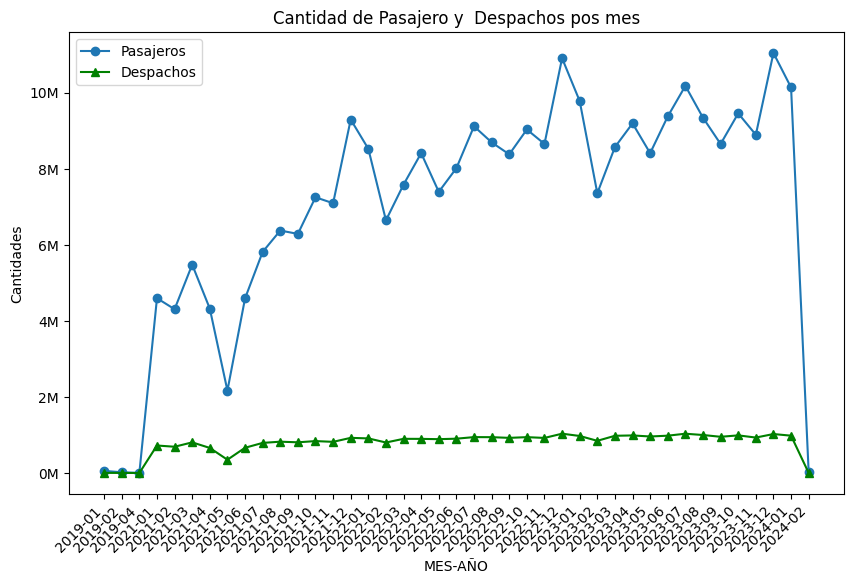

In [25]:
#Primero será necesario agrupar los datos por mes-año según Fecha Despacho
data['FECHA_DESPACHO'] = pd.to_datetime(data['FECHA_DESPACHO'])
data['MES-AÑO'] = data['FECHA_DESPACHO'].dt.to_period('M')
data_agrupada = grupo_por_columna(data, 'MES-AÑO')


data_agrupada['Variación Despachos(%)'] = (data_agrupada['DESPACHOS'].pct_change() * 100).round(2)
data_agrupada['Variación Pasajeros (%)'] = (data_agrupada['PASAJEROS'].pct_change() * 100).round(2)

print(data_agrupada)
print(data_agrupada)
data_agrupada['MES-AÑO'] = data_agrupada['MES-AÑO'].astype(str)

#Graficar los datos
plt.figure(figsize=(10,6))
ax = plt.gca()
plt.plot(data_agrupada['MES-AÑO'], data_agrupada['PASAJEROS'], label = 'Pasajeros', marker = 'o')
plt.plot(data_agrupada['MES-AÑO'], data_agrupada['DESPACHOS'], label = 'Despachos', marker = '^', color='green')
ax.yaxis.set_major_formatter(FuncFormatter(formato_ejes))
plt.xlabel('MES-AÑO')
plt.ylabel('Cantidades')
plt.title('Cantidad de Pasajero y  Despachos pos mes')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

Ya que estamos observando la data con base en un rango de 4 años, es interesante poder observar los máximos y mínimos de este, aunque de entrada se observa que los datos del último mes registrado del 2024 (año actual) aun están incompletos lo ideal es rescatar el menor valor sin contemplar este mes sin finalizar. Gracias a la gráfica anterior, el patrón de ambos valores es el mismo, por lo cual se observará el mínimo y máximo de ambos valores independientes en los mismos meses.

In [26]:
#Contempletar datos agrupados sin el último mes en cuestión
data_agrupada_sin_último_mes = data_agrupada.iloc[:-1]

# mes con el menor y mayor cantidad de despachos
mes_menor_despachos = data_agrupada_sin_último_mes.loc[data_agrupada_sin_último_mes['DESPACHOS'].idxmin()]
mes_mayor_despachos = data_agrupada.loc[data_agrupada['DESPACHOS'].idxmax()]

# Extraer los pasajeros según el mínimo anterior
pasajeros_menor_despacho = mes_menor_despachos['PASAJEROS']
pasajeros_mayor_despacho = mes_mayor_despachos['PASAJEROS']

#Imprimir y observar resúltados
print(f"Mes con el mínimo general: {mes_menor_despachos['MES-AÑO']}, Despachos: {mes_menor_despachos['DESPACHOS']}, Pasajeros: {pasajeros_menor_despacho}")
print(f"Mes con el máximo general: {mes_mayor_despachos['MES-AÑO']}, Despachos: {mes_mayor_despachos['DESPACHOS']}, Pasajeros: {pasajeros_mayor_despacho}")


Mes con el mínimo general: 2019-04, Despachos: 54, Pasajeros: 885
Mes con el máximo general: 2022-12, Despachos: 1033279, Pasajeros: 10905662


De entrada, el histórico, que nos muestra datos desde los últimos 4 meses del 2019 hasta el mes casi actual del presente año. Se evidencia que la pandemía afectó en gran medida el transporte terrestre de pasajeros. Gracias el máximo y mínimo, se observa que no se ha logrado romper el máximo histórico después de pandemia, lo cuál parece que el viaje a través de terminales terrestres aun requiere esfuerzos para volver a obtener alto tráfico, o existen más autos familiares en carreteras nacionales. No obstante, el año 2023 comenzó casi acercandose a este máximo hitórico, lo cuál debió incrementar esperanzas en las compañías de transporte sobre la expectativas de viaje para este año.

Adicional, como se mencionó antes, el patrón de demanda y oferta de transporte es cohorente y sugiere que se abarca en mejor medida en todo el tiempo recorrido

In [27]:
#Correlación Despachos-Pasajeros
corr = round(data['PASAJEROS'].corr(data['DESPACHOS']), 4)

print(f'Las 2 variables principales entregan una correlación de {corr} lo cual implica que tienden a ser directamente proporcionales entre sí')

Las 2 variables principales entregan una correlación de 0.6445 lo cual implica que tienden a ser directamente proporcionales entre sí


### Variación anual Despachos y Pasajeros
Ya vista la tendencia general en cada uno de los meses presentes en el conjunto de datos, podemos entrar en más detalle sobre esto, observando ésta a nivel de Departamento de Origen, en cuestión anual

In [28]:
#Agrupar la data por fecha de despacho considerando únicamente el año
data['FECHA_DESPACHO'] = pd.to_datetime(data['FECHA_DESPACHO'])
data['AÑO'] = data['FECHA_DESPACHO'].dt.to_period('Y')

#Se agrupa y se presenta en tabla, agregando la varión año a año para cada variable
tendencia_anual_por_departamento = grupo_por_columna(data, ['DEPARTAMENTO_ORIGEN', 'AÑO'])
tendencia_anual_por_departamento['Pasajeros YoY'] = (tendencia_anual_por_departamento.groupby('DEPARTAMENTO_ORIGEN')['PASAJEROS'].pct_change()*100).round(2)
tendencia_anual_por_departamento['Despachos YoY'] = (tendencia_anual_por_departamento.groupby('DEPARTAMENTO_ORIGEN')['DESPACHOS'].pct_change()*100).round(2)
print(tendencia_anual_por_departamento)

#En este punto es necesario indagar en cómo evitar el resultado de variación para años no consecutivos

    DEPARTAMENTO_ORIGEN   AÑO  PASAJEROS  DESPACHOS  Pasajeros YoY  \
0             ANTIOQUIA  2021    9458314    1115572            NaN   
1             ANTIOQUIA  2022   12989999    1248182          37.34   
2             ANTIOQUIA  2023   14585711    1314276          12.28   
3             ANTIOQUIA  2024    1219023      93540         -91.64   
4                ARAUCA  2021       2360        278            NaN   
..                  ...   ...        ...        ...            ...   
106     VALLE DEL CAUCA  2022   15382087    1657128          54.22   
107     VALLE DEL CAUCA  2023   14999800    1638331          -2.49   
108     VALLE DEL CAUCA  2024    1278201     129819         -91.48   
109             VICHADA  2022          5          2            NaN   
110             VICHADA  2023         10          1         100.00   

     Despachos YoY  
0              NaN  
1            11.89  
2             5.30  
3           -92.88  
4              NaN  
..             ...  
106         

In [29]:
#Adicional podemos observar la tendencia mensual para cada departamento de origen
data['FECHA_DESPACHO'] = pd.to_datetime(data['FECHA_DESPACHO'])
data['MES'] = data['FECHA_DESPACHO'].dt.to_period('M')


#Calcular la variación interanual de las variables por Departamento de Origen
tendencia_anual_por_departamento_mes = grupo_por_columna(data, ['DEPARTAMENTO_ORIGEN', 'MES'])
tendencia_anual_por_departamento_mes['Pasajeros MoM'] = (tendencia_anual_por_departamento_mes.groupby('DEPARTAMENTO_ORIGEN')['PASAJEROS'].pct_change()*100).round(2)
tendencia_anual_por_departamento_mes['Despachos MoM'] = (tendencia_anual_por_departamento_mes.groupby('DEPARTAMENTO_ORIGEN')['DESPACHOS'].pct_change()*100).round(2)
print(tendencia_anual_por_departamento_mes)

#Indagar sobre el resultado para varaición en meses no consecutivos

     DEPARTAMENTO_ORIGEN      MES  PASAJEROS  DESPACHOS  Pasajeros MoM  \
0              ANTIOQUIA  2021-01     659283      93215            NaN   
1              ANTIOQUIA  2021-02     630285      89571          -4.40   
2              ANTIOQUIA  2021-03     778790     102068          23.56   
3              ANTIOQUIA  2021-04     517836      73993         -33.51   
4              ANTIOQUIA  2021-05     505679      76372          -2.35   
...                  ...      ...        ...        ...            ...   
1023     VALLE DEL CAUCA  2024-01    1277756     129773           3.58   
1024     VALLE DEL CAUCA  2024-02        445         46         -99.97   
1025             VICHADA  2022-09          1          1            NaN   
1026             VICHADA  2022-11          4          1         300.00   
1027             VICHADA  2023-04         10          1         150.00   

      Despachos MoM  
0               NaN  
1             -3.91  
2             13.95  
3            -27.51  
4

En teoría, gracias a que los datos del 2019 no abarcan el año completo, la variación observada para el 2020 representaría una cambio alto, no obstante lo sucedido en este año mantuvo ambas variables en una punto constante para ambos años en la mayoría de departamentos. Así mismo, en algunos de estos los despachos mantuvieron cierta normalidad en algunos meses del segundo año. No obstante, la recuperación en el transporte terrestre es observables desde el segundo semestre del 2021 donde las restricciones de pandemia empezaron a obtener mayor flexibilidad.

Tabla por hora despacho:
 HORA_DESPACHO  PASAJEROS  DESPACHOS  PORCENTAJE_PASAJEROS  PORCENTAJE_DESPACHOS
             0    2340918     159181                  0.81                  0.49
             1    1815091     135396                  0.63                  0.42
             2    1902421     147232                  0.66                  0.45
             3    2537681     237648                  0.88                  0.73
             4    5069199     638247                  1.75                  1.96
             5    9502803    1301674                  3.28                  4.00
             6   13796910    1890199                  4.77                  5.81
             7   14371675    2012868                  4.97                  6.19
             8   15624028    2103499                  5.40                  6.47
             9   16254010    2115848                  5.62                  6.50
            10   17412032    2173561                  6.02                  6.68
   

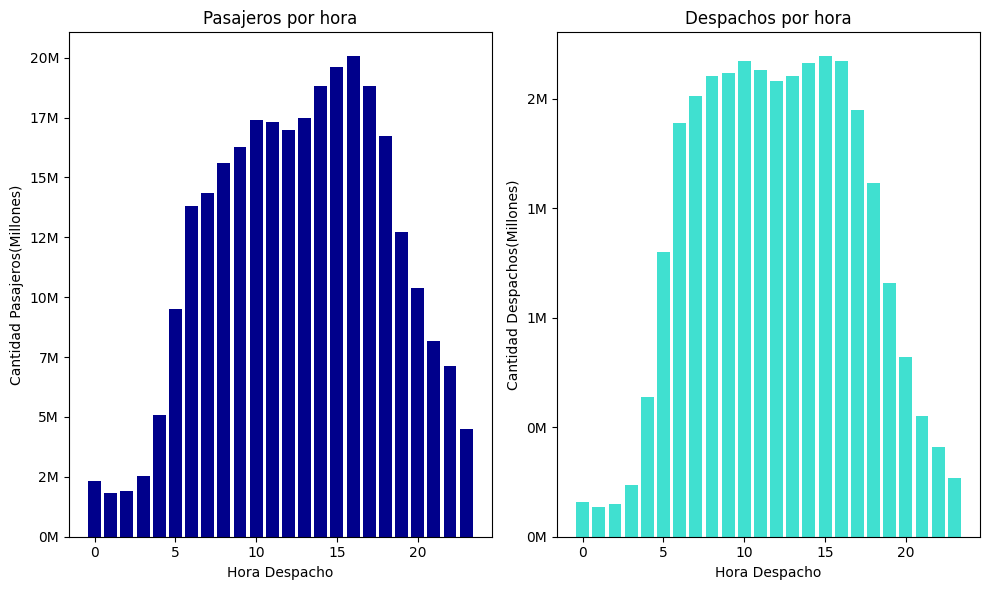

In [30]:
#Ahora observaremos los despachos y pasajeros por horas de despacho
data_por_hora_despacho = grupo_por_columna(data, 'HORA_DESPACHO')
#Calcular las roporciones por hora de despacho
data_por_hora_despacho['PORCENTAJE_PASAJEROS'] = ((data_por_hora_despacho['PASAJEROS'] / total_pasajeros) * 100).round(2)
data_por_hora_despacho['PORCENTAJE_DESPACHOS'] = ((data_por_hora_despacho['DESPACHOS'] / total_despachos) * 100).round(2)
print('Tabla por hora despacho:')
print(data_por_hora_despacho.to_string(index=False))

#Máximos por Hora de despacho
hora_menos_despachos = data_por_hora_despacho.loc[data_por_hora_despacho['DESPACHOS'].idxmin()]
pasajeros_hora_menos_despachos = hora_menos_despachos['PASAJEROS']
hora_mas_despachos = data_por_hora_despacho.loc[data_por_hora_despacho['DESPACHOS'].idxmax()]
pasajeros_hora_mas_despachos = hora_mas_despachos['PASAJEROS']
print(f"Hora menos Despachos: {hora_menos_despachos['HORA_DESPACHO']}, Despachos:{hora_menos_despachos['DESPACHOS']}, Pasajeros:{pasajeros_hora_menos_despachos}")
print(f"Hora más Despachos: {hora_mas_despachos['HORA_DESPACHO']}, Despachos:{hora_mas_despachos['DESPACHOS']}, Pasajeros:{pasajeros_hora_mas_despachos}")

#Mínimos por hora de despacho
hora_menos_pasajeros = data_por_hora_despacho.loc[data_por_hora_despacho['PASAJEROS'].idxmin()]
despachos_hora_menos_pasajeros = hora_menos_pasajeros['DESPACHOS']
hora_mas_pasajeros = data_por_hora_despacho.loc[data_por_hora_despacho['PASAJEROS'].idxmax()]
despachos_hora_mas_pasajeros = hora_mas_despachos['DESPACHOS']
print(f"Hora menos Pasajeross: {hora_menos_pasajeros['HORA_DESPACHO']}, Pasajeros:{hora_menos_pasajeros['PASAJEROS']}, Despachos:{despachos_hora_menos_pasajeros}")
print(f"Hora más Pasajeros: {hora_mas_pasajeros['HORA_DESPACHO']}, Pasajeros:{hora_mas_pasajeros['PASAJEROS']}, Despachos:{despachos_hora_mas_pasajeros}")

#Gráfica 
plt.figure(figsize=(10, 6))

plt.subplot(1,2,1)
plt.bar(data_por_hora_despacho['HORA_DESPACHO'], data_por_hora_despacho['PASAJEROS'], color='darkblue')
plt.xlabel('Hora Despacho')
plt.ylabel('Cantidad Pasajeros(Millones)')
plt.title('Pasajeros por hora')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(formato_ejes))


plt.subplot(1,2,2)
plt.bar(data_por_hora_despacho['HORA_DESPACHO'], data_por_hora_despacho['DESPACHOS'], color = 'turquoise')
plt.xlabel('Hora Despacho')
plt.ylabel('Cantidad Despachos(Millones)')
plt.title('Despachos por hora')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(formato_ejes))

plt.tight_layout()
plt.show()

Es curioso ver que a pesar del saber común en el país donde se considera mejor viajar por la noche, la concentración de despachos y pasajeros se distribuye en horas del día, entre las 7a.m. y 6p.m.. Puede deberse a las condiciones de la carreteras en estos momentos o como veremos más adelante el destino de la mayoría de despachos ejecutados por departamento.

Tabla por clase de vehículo
  CLASE_VEHICULO  PASAJEROS  DESPACHOS  PORCENTAJE_PASAJEROS  \
1            BUS  137474975   11477682                 47.51   
5       MICROBUS   95133903   11845076                 32.88   
2         BUSETA   26991427    3574306                  9.33   
3      CAMIONETA   20792519    3622014                  7.19   
4        CAMPERO    5038581     766590                  1.74   
0      AUTOMOVIL    3940645    1248179                  1.36   

   PORCENTAJE_DESPACHOS  PASAJERO_PROM_POR_VEHÍCULO  
1                 35.28                       11.98  
5                 36.41                        8.03  
2                 10.99                        7.55  
3                 11.13                        5.74  
4                  2.36                        6.57  
0                  3.84                        3.16  


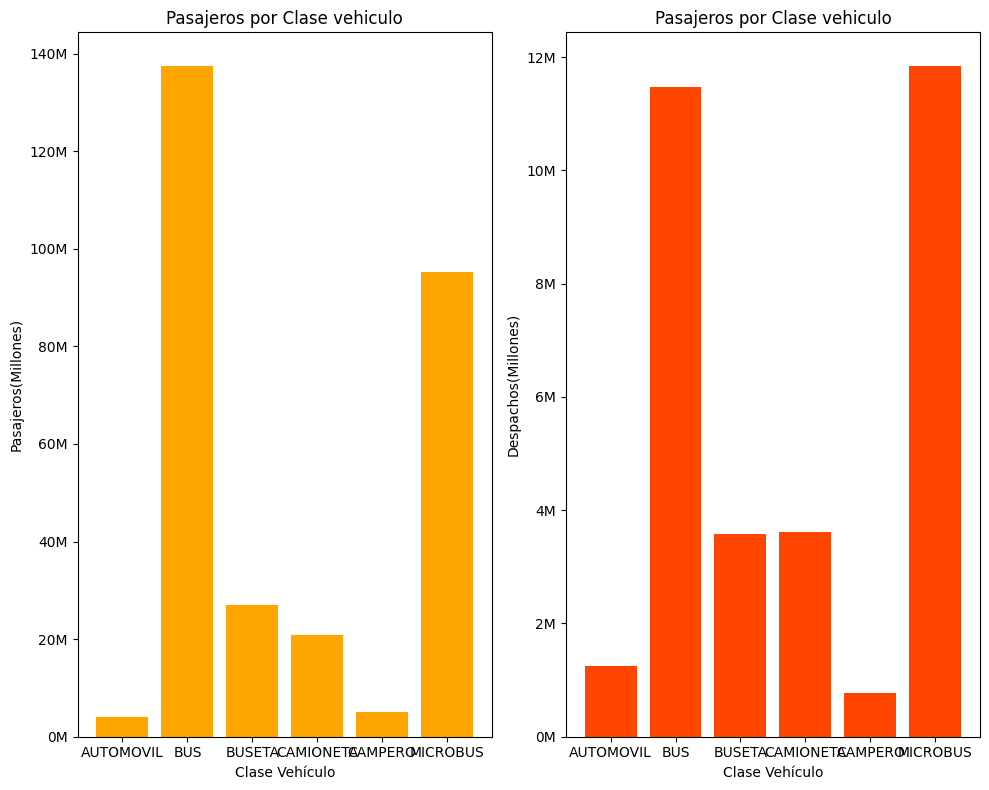

In [31]:
#Ahora se agrupará y presentarán los depachos y pasajeros por tipo de vehículo
data_por_vehiculo = grupo_por_columna(data, 'CLASE_VEHICULO')
#Proporciones por clase de vehículo
data_por_vehiculo['PORCENTAJE_PASAJEROS'] = ((data_por_vehiculo['PASAJEROS'] / total_pasajeros) * 100).round(2)
data_por_vehiculo['PORCENTAJE_DESPACHOS'] = ((data_por_vehiculo['DESPACHOS'] / total_despachos) * 100).round(2)
data_por_vehiculo['PASAJERO_PROM_POR_VEHÍCULO'] = (data_por_vehiculo['PASAJEROS']/data_por_vehiculo['DESPACHOS']).round(2)
#Presentar resultados en formato de tabla
print('Tabla por clase de vehículo')
print(data_por_vehiculo.sort_values('PASAJEROS', ascending=False))

#Gráfica 
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
plt.bar(data_por_vehiculo['CLASE_VEHICULO'], data_por_vehiculo['PASAJEROS'], color = 'orange')
plt.xlabel('Clase Vehículo')
plt.ylabel('Pasajeros(Millones)')
plt.title('Pasajeros por Clase vehiculo')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(formato_ejes))

plt.subplot(1,2,2)
plt.bar(data_por_vehiculo['CLASE_VEHICULO'], data_por_vehiculo['DESPACHOS'], color = 'orangered')
plt.xlabel('Clase Vehículo')
plt.ylabel('Despachos(Millones)')
plt.title('Pasajeros por Clase vehiculo')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(formato_ejes))

plt.tight_layout()
plt.show()


Si bien la data parece recogerse a través de las terminales de transporte de cada departamento, la clase de vehículos contempla medios de transporte con bajo cupo de pasajeros (Automóvil, Camioneta y Campero), adicional parece que la camioneta ofrece capacidad de pasajeros casi similar a la buseta, según la proporción observada. Es curioso porque implica que son viajes personalizados adquiridos o que son de distancias cortas y que las Empresas de Transporte intermunicipal ofrecen servicio a este nivel de distribución.

Tabla por Nivel de Servicio
         NIVEL_SERVICIO  PASAJEROS  DESPACHOS  PORCENTAJE_PASAJEROS  \
1                  LUJO  176094384   20054639                 60.85   
0                BASICO  113189637   12475948                 39.12   
2  PREFERENCIAL DE LUJO      88029       3260                  0.03   

   PORCENTAJE_DESPACHOS  
1                 61.64  
0                 38.35  
2                  0.01  


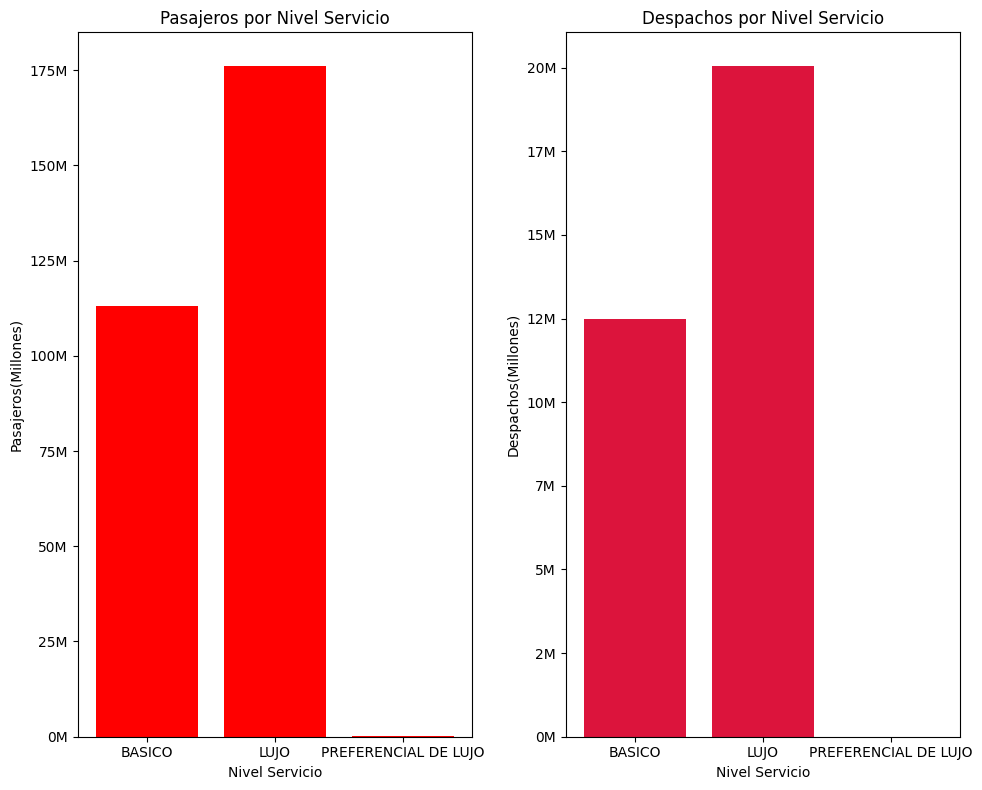

In [32]:
#Ahora se agrupará y presentarán los depachos y pasajeros por tipo de vehículo y se calcularán las proporciones por
#tipo de servicio
data_por_servicio = grupo_por_columna(data, 'NIVEL_SERVICIO')

#Proporciones por nivel de servicio
data_por_servicio['PORCENTAJE_PASAJEROS'] = ((data_por_servicio['PASAJEROS'] / total_pasajeros) * 100).round(2)
data_por_servicio['PORCENTAJE_DESPACHOS'] = ((data_por_servicio['DESPACHOS'] / total_despachos) * 100).round(2)
print('Tabla por Nivel de Servicio')
print(data_por_servicio.sort_values('PASAJEROS', ascending=False))

#Gráfica 
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
plt.bar(data_por_servicio['NIVEL_SERVICIO'], data_por_servicio['PASAJEROS'], color = 'red')
plt.xlabel('Nivel Servicio')
plt.ylabel('Pasajeros(Millones)')
plt.title('Pasajeros por Nivel Servicio')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(formato_ejes))

plt.subplot(1,2,2)
plt.bar(data_por_servicio['NIVEL_SERVICIO'], data_por_servicio['DESPACHOS'], color = 'crimson')
plt.xlabel('Nivel Servicio')
plt.ylabel('Despachos(Millones)')
plt.title('Despachos por Nivel Servicio')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(formato_ejes))

plt.tight_layout()
plt.show()


In [33]:
#Dado que hay cierto tipo de vehículos cuya carga de pasajeros es más pequeña, se hará una observación de estos en varias
#de sus características
vehiculo_pequeño = grupo_por_columna(data, ['CLASE_VEHICULO', 'NIVEL_SERVICIO'])
vehiculo_pequeño = vehiculo_pequeño.loc[(vehiculo_pequeño['CLASE_VEHICULO'] == 'AUTOMOVIL') | (vehiculo_pequeño['CLASE_VEHICULO'] == 'CAMPERO')]
print('Data carros pequeños')
print(vehiculo_pequeño)

Data carros pequeños
   CLASE_VEHICULO NIVEL_SERVICIO  PASAJEROS  DESPACHOS
0       AUTOMOVIL         BASICO    1648338     507229
1       AUTOMOVIL           LUJO    2292307     740950
11        CAMPERO         BASICO    3570571     481341
12        CAMPERO           LUJO    1468010     285249


Así bien, puede entenderse que el nivel de servicio preferencial de lujo debe ser un servicio adquirido de forma especial por agencia, mientras que lujo puede relacionarse a paquetes de turismo. No hay un diccionario en la data para entender esta referencia, así mismo, no se hace exclusivo de vehículos pequeños y puede observarse sobre los vehículos más grandes también.

Tabla por Departamento de Origen
   DEPARTAMENTO_ORIGEN  PASAJEROS  DESPACHOS  PORCENTAJE_PASAJEROS  \
3         BOGOTÁ, D.C.   47015037    5255325                 16.25   
26     VALLE DEL CAUCA   41633965    4759691                 14.39   
0            ANTIOQUIA   38253047    3771570                 13.22   
5               BOYACÁ   21657298    2707630                  7.48   
21             QUINDÍO   12743238    1826375                  4.40   
22           RISARALDA   13644686    1634779                  4.72   
14               HUILA   13144416    1435508                  4.54   
18              NARIÑO   12998048    1374828                  4.49   
25              TOLIMA   12257161    1342066                  4.24   
6               CALDAS    7768636     864988                  2.68   
19  NORTE DE SANTANDER    5876361     819370                  2.03   
4              BOLÍVAR    8449755     755465                  2.92   
2            ATLÁNTICO    5967083     702175             

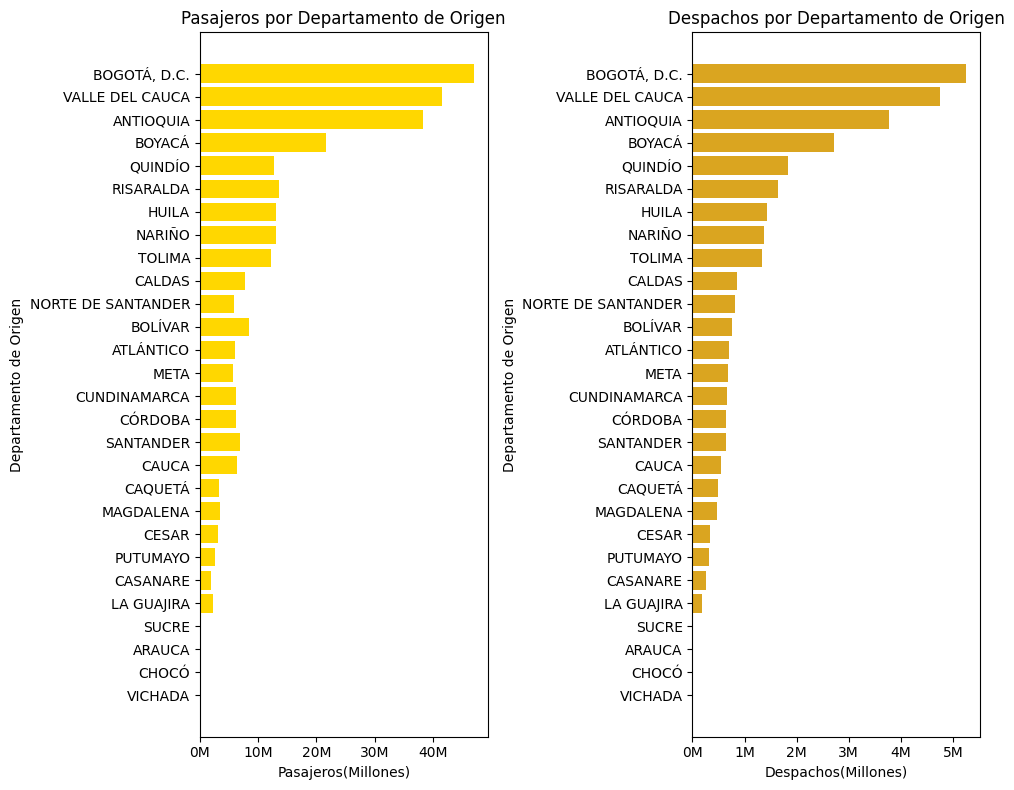

In [34]:
#Ahora se agrupará y presentarán los depachos y pasajeros departamento de origen
data_por_departamento_origen = grupo_por_columna(data, 'DEPARTAMENTO_ORIGEN')

#Proporciones por dapartamento de origne
data_por_departamento_origen['PORCENTAJE_PASAJEROS'] = ((data_por_departamento_origen['PASAJEROS'] / total_pasajeros) * 100).round(2)
data_por_departamento_origen['PORCENTAJE_DESPACHOS'] = ((data_por_departamento_origen['DESPACHOS'] / total_despachos) * 100).round(2)

#En este caso se ordenarán de mayor a menos los valores por el campo de Despachos de esta forma para que 
#en la gráfica obtengamos este mismo orden
data_por_departamento_origen = data_por_departamento_origen.sort_values('DESPACHOS', ascending=False)

print('Tabla por Departamento de Origen')
print(data_por_departamento_origen)

#Gráfica 
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
plt.barh(data_por_departamento_origen['DEPARTAMENTO_ORIGEN'], data_por_departamento_origen['PASAJEROS'], color = 'gold')
plt.xlabel('Pasajeros(Millones)')
plt.ylabel('Departamento de Origen')
plt.title('Pasajeros por Departamento de Origen')
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(formato_ejes))

plt.subplot(1,2,2)
plt.barh(data_por_departamento_origen['DEPARTAMENTO_ORIGEN'], data_por_departamento_origen['DESPACHOS'], color = 'goldenrod')
plt.xlabel('Despachos(Millones)')
plt.ylabel('Departamento de Origen')
plt.title('Despachos por Departamento de Origen')
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(formato_ejes))

plt.tight_layout()
plt.show()


Tabla por Departamento de Destino
   DEPARTAMENTO_DESTINO  PASAJEROS  DESPACHOS  PORCENTAJE_PASAJEROS  \
27      VALLE DEL CAUCA   37849904    4032156                 13.08   
0             ANTIOQUIA   37433176    3875037                 12.94   
3          BOGOTÁ, D.C.   31782566    2390921                 10.98   
5                BOYACÁ   21165426    2806996                  7.31   
12         CUNDINAMARCA   16075155    2490144                  5.56   
22              QUINDÍO   12982294    1763013                  4.49   
19               NARIÑO   12974684    1341748                  4.48   
15                HUILA   11481912    1415720                  3.97   
26               TOLIMA   11249725    1452190                  3.89   
6                CALDAS    9042384    1084318                  3.12   
23            RISARALDA    8946117    1214224                  3.09   
24            SANTANDER    8576287     912438                  2.96   
4               BOLÍVAR    7688766     7601

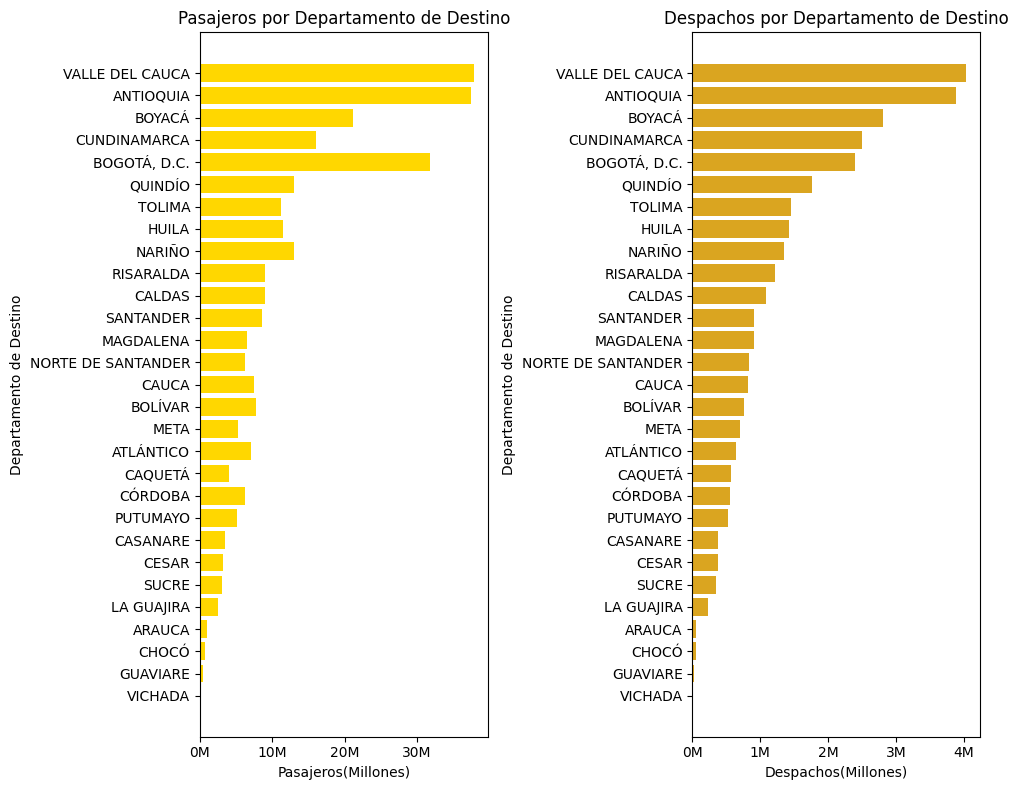

In [35]:
#Ahora se agrupará y presentarán los depachos y pasajeros por departamento de destino
data_por_departamento_destino = grupo_por_columna(data, 'DEPARTAMENTO_DESTINO')

#Proporciones por nivel de destino
data_por_departamento_destino['PORCENTAJE_PASAJEROS'] = ((data_por_departamento_destino['PASAJEROS'] / total_pasajeros) * 100).round(2)
data_por_departamento_destino['PORCENTAJE_DESPACHOS'] = ((data_por_departamento_destino['DESPACHOS'] / total_despachos) * 100).round(2)

#En este caso se ordenarán de mayor a menos los valores por el campo de Despachos de esta forma para que 
#en la gráfica obtengamos este mismo orden
data_por_departamento_destino = data_por_departamento_destino.sort_values('DESPACHOS', ascending=False)

print('Tabla por Departamento de Destino')
print(data_por_departamento_destino.sort_values('PASAJEROS', ascending=False))

#Gráfica 
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
plt.barh(data_por_departamento_destino['DEPARTAMENTO_DESTINO'], data_por_departamento_destino['PASAJEROS'], color = 'gold')
plt.xlabel('Pasajeros(Millones)')
plt.ylabel('Departamento de Destino')
plt.title('Pasajeros por Departamento de Destino')
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(formato_ejes))

plt.subplot(1,2,2)
plt.barh(data_por_departamento_destino['DEPARTAMENTO_DESTINO'], data_por_departamento_destino['DESPACHOS'], color = 'goldenrod')
plt.xlabel('Despachos(Millones)')
plt.ylabel('Departamento de Destino')
plt.title('Despachos por Departamento de Destino')
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(formato_ejes))

plt.tight_layout()
plt.show()


La vista general entre origenes y destino, ofrece 2 focos de concentración interesantes. Gran cantidad de viajes salen desde la Capital del país y éste mismo se ubica en el 3er puesto de recepción de pasajeros, mientras que el Valle del Cauca, el departamento ubicado más al sur con gran afluencia en las variables, entrega el segundo punto de origenes de viajes y obtiene el primer puesto como destino predilecto de éstos. Seguidos de Antioquia entre los departamentos de renombre.

DEPARTAMENTO_DESTINO  ANTIOQUIA  ARAUCA  ATLÁNTICO  BOGOTÁ, D.C.  BOLÍVAR  \
DEPARTAMENTO_ORIGEN                                                         
ANTIOQUIA               3243472       0      17452         50863    31651   
ARAUCA                        0     832          0          4845        0   
ATLÁNTICO                 19589       0         91         36455   138813   
BOGOTÁ, D.C.              30873   37224      20206          4031    80118   
BOLÍVAR                   21217       0     110222         53513   356154   
BOYACÁ                        3     308          0        480842      160   
CALDAS                    39443       0          2         47168     2883   
CAQUETÁ                    3416       0          0         26112        0   
CASANARE                     58    3069          0         65439        0   
CAUCA                      2069       0          0          8419        9   
CESAR                      4647       0      48745         16295     1177   

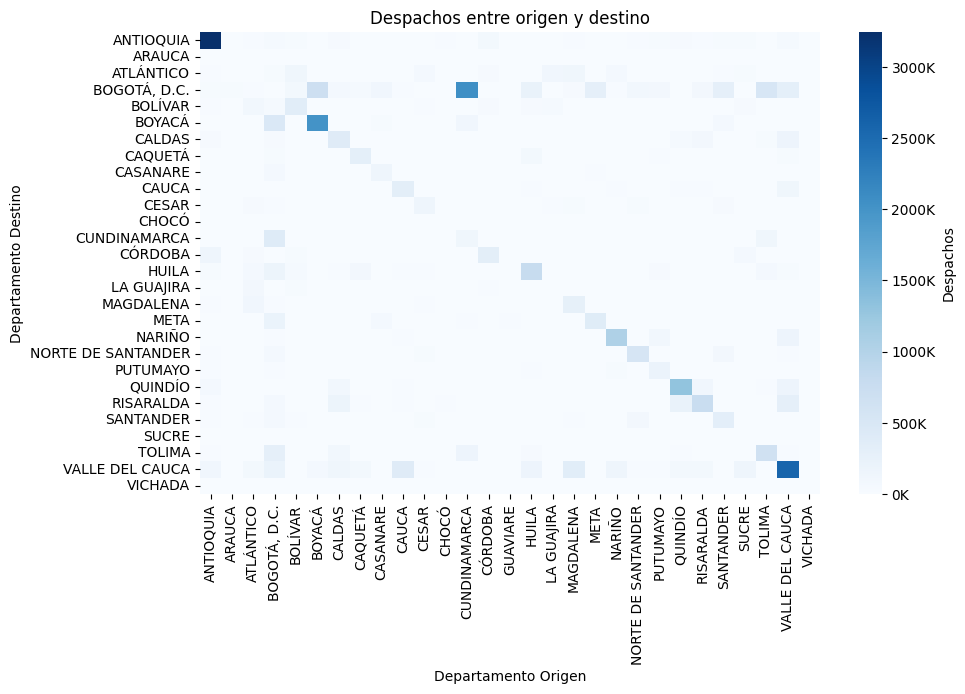

In [36]:
#Despachos entre origen y destino
origen_vs_destino = data.pivot_table(index = 'DEPARTAMENTO_ORIGEN', columns = 'DEPARTAMENTO_DESTINO',
                                      values = 'DESPACHOS', aggfunc='sum', fill_value=0)
print(origen_vs_destino)

#Fromato barra de color para el mapa de calor
def formato_mapa(x, pos):
    return f'{int(x/1e3)}K'
#Gráfica
plt.figure(figsize = (10,6))
sns.heatmap(origen_vs_destino, cmap = 'Blues', cbar_kws={'label': 'Despachos', 'format': FuncFormatter(formato_mapa)})
plt.title('Despachos entre origen y destino')
plt.xlabel('Departamento Origen')
plt.ylabel('Departamento Destino')
plt.show()

Básicamente viendo la distribución del mapa de calor, se explica de mejor forma el comportamiento de destino-origen y el tipo de vehículo implementado, puesto que esta data, fuera de lo esperado para el análisis en cuestión, presenta comportamiento de viajes sobretodo al interior de cada departamento, ubicando gran afluencia de, posiblemente, viajes de trabajo en municipios aledaños (por eso la distribución de horas), viajes de turismo cortos. O casos como el de Bogotá D.C. requerimientos, vueltas personales y de salud de comunidades del departamento de Cundinamarca que deben ir a la capital a suplir sus necesidades, entre otras razones más por explorar.

In [37]:
#Dada la distribución de los departamentos, es interesante observar la cantidad de destinos que estos realizan
dept_origen_destinos_unicos = grupo_por_columna(data,'DEPARTAMENTO_ORIGEN')
dept_origen_destinos_unicos['Municipios Origen Únicos'] = data.groupby('DEPARTAMENTO_ORIGEN')['MUNICIPIO_ORIGEN'].nunique().reset_index(drop=True)
dept_origen_destinos_unicos['Destinos Únicos'] = data.groupby('DEPARTAMENTO_ORIGEN')['DEPARTAMENTO_DESTINO'].nunique().reset_index(drop=True)
dept_origen_destinos_unicos['Municipios Destino Únicos'] = data.groupby('DEPARTAMENTO_ORIGEN')['MUNICIPIO_DESTINO'].nunique().reset_index(drop=True)
print(dept_origen_destinos_unicos.sort_values('DESPACHOS', ascending=False))

   DEPARTAMENTO_ORIGEN  PASAJEROS  DESPACHOS  Municipios Origen Únicos  \
3         BOGOTÁ, D.C.   47015037    5255325                         1   
26     VALLE DEL CAUCA   41633965    4759691                        16   
0            ANTIOQUIA   38253047    3771570                        11   
5               BOYACÁ   21657298    2707630                        70   
21             QUINDÍO   12743238    1826375                         2   
22           RISARALDA   13644686    1634779                        11   
14               HUILA   13144416    1435508                        19   
18              NARIÑO   12998048    1374828                        10   
25              TOLIMA   12257161    1342066                        30   
6               CALDAS    7768636     864988                        16   
19  NORTE DE SANTANDER    5876361     819370                         6   
4              BOLÍVAR    8449755     755465                         3   
2            ATLÁNTICO    5967083     

Sin embargo, la data general ofrece que los departamento principales distribuyen viajes y pasajeros a casi todos los departamentos posibles, lo cual hace que se deba implementar otras opciones de exploración para dar la explicación concreta del comportamiento de viajes en este conjunto de datos.

In [38]:
#Y en el caso contrario también
dept_destino_origen_unico = grupo_por_columna(data,'DEPARTAMENTO_DESTINO')
dept_destino_origen_unico['Origenes Únicos'] = data.groupby('DEPARTAMENTO_DESTINO')['DEPARTAMENTO_ORIGEN'].nunique().reset_index(drop=True)
print(dept_destino_origen_unico.sort_values('DESPACHOS', ascending=False))


   DEPARTAMENTO_DESTINO  PASAJEROS  DESPACHOS  Origenes Únicos
27      VALLE DEL CAUCA   37849904    4032156               20
0             ANTIOQUIA   37433176    3875037               23
5                BOYACÁ   21165426    2806996               15
12         CUNDINAMARCA   16075155    2490144               11
3          BOGOTÁ, D.C.   31782566    2390921               27
22              QUINDÍO   12982294    1763013               12
26               TOLIMA   11249725    1452190               17
15                HUILA   11481912    1415720               17
19               NARIÑO   12974684    1341748               12
23            RISARALDA    8946117    1214224               16
6                CALDAS    9042384    1084318               22
24            SANTANDER    8576287     912438               17
17            MAGDALENA    6480831     905954               14
20   NORTE DE SANTANDER    6193486     833915               19
9                 CAUCA    7520659     818918          

In [39]:
mun_destino_origen_unico = grupo_por_columna(data,'MUNICIPIO_DESTINO')
mun_destino_origen_unico['Origenes Únicos'] = data.groupby('MUNICIPIO_DESTINO')['MUNICIPIO_ORIGEN'].nunique().reset_index(drop=True)
print(mun_destino_origen_unico.sort_values('DESPACHOS', ascending=False))

       MUNICIPIO_DESTINO  PASAJEROS  DESPACHOS  Origenes Únicos
79          BOGOTÁ, D.C.   31782566    2390921              192
609     SANTIAGO DE CALI   16607924    1358522               73
413                NEIVA    5171957     619010               47
634             SOGAMOSO    5750573     591919               39
600  SANTA ROSA DE CABAL    2185226     548833                1
..                   ...        ...        ...              ...
264             GUACHENÉ          6          1                1
674             TIBASOSA          1          1                1
416              NIMAIMA          4          1                1
366              MALLAMA          8          1                1
121    CASTILLA LA NUEVA          1          1                1

[758 rows x 4 columns]


In [40]:
mun_origen_destino_unico = grupo_por_columna(data,'MUNICIPIO_ORIGEN')
mun_origen_destino_unico['Destinos Únicos'] = data.groupby('MUNICIPIO_ORIGEN')['MUNICIPIO_DESTINO'].nunique().reset_index(drop=True)
print(mun_origen_destino_unico.sort_values('DESPACHOS', ascending=False))

     MUNICIPIO_ORIGEN  PASAJEROS  DESPACHOS  Destinos Únicos
35       BOGOTÁ, D.C.   47015037    5255325              299
260  SANTIAGO DE CALI   31194722    3553080               93
152          MEDELLÍN   33366718    2827803              168
19            ARMENIA   12749581    1826892               41
196           PEREIRA   13641444    1634257               51
..                ...        ...        ...              ...
206       PUEBLO RICO          8          1                1
214      PUERTO LÓPEZ          1          1                1
227            ROVIRA          9          1                1
232           SALDAÑA         12          1                1
313            YOTOCO          8          1                1

[314 rows x 4 columns]


### **Observación General**

La data recolectada, si bien menciona que se origina desde cada Terminal registrada, puede ahondarse en dar mayor claridad sobre el nivel de servicio mencionado, y gracias a data de otras fuentes podría darse explicaciones más profundas en el asunto. Así mismo, la concentración de viajes al interior de cada departamento, puedría considerar poder ampliar las características de registro de información, conociendo el tipo de viaje realizado en ciertos pasajeros. Es un conjunto apto para conocer el comportamiento de pasajeros, y el fin principal de análisis no hay información explícita sobre las compañías que registraron la data, para dar una mayor relación en la partipación de éstas, la recuperación de sus servicios desde la pandemia y demás características para indagar en el portafolio ofrecido.

In [41]:
# Nombre del archivo Excel en el que se guardarán las hojas
#nombre_archivo_excel = 'TablasPruebaPinbusDC.xlsx'

# Crear un objeto ExcelWriter para guardar los DataFrames en un archivo Excel
#writer = pd.ExcelWriter(nombre_archivo_excel, engine='xlsxwriter')

# Escribir cada DataFrame en una hoja separada en el archivo Excel
#data_agrupada.to_excel(writer, sheet_name='Tendencia y variación Mensual', index=False)
#tendencia_anual_por_departamento.to_excel(writer, sheet_name='Tendencia Anual Departamento', index=False)
#tendencia_anual_por_departamento_mes.to_excel(writer, sheet_name='Tendencia Mensual Departamento', index=False)
#data_por_hora_despacho.to_excel(writer, sheet_name='Desp&Pas Hora Despacho', index=False)
#data_por_vehiculo.to_excel(writer, sheet_name='Desp6Pas Tipo Vehiculo', index=False)
#data_por_servicio.to_excel(writer, sheet_name='Desp6Pas Nivel de Servicio', index=False)
#data_por_departamento_origen.to_excel(writer, sheet_name='Des&Pas Departamento Origen', index=False)
#data_por_departamento_destino.to_excel(writer, sheet_name='Desp&Pas Departamento Destino', index=False)
#origen_vs_destino.to_excel(writer, sheet_name='Desp&Pas Origen-Destino', index=False)
#dept_origen_destinos_unicos.to_excel(writer, sheet_name='Destinos Unicos por Origen', index=False)
#dept_destino_origen_unico.to_excel(writer, sheet_name='Origen Unico por Destino', index=False)

# Guardar el archivo Excel
#writer.close()

#print("DataFrames guardados en el archivo Excel con hojas separadas.")
